# Continuous Control

---
In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment
We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

import numpy as np
import random
from collections import deque
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
# environment configuration
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# environment information
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 20
Number of actions: 4
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
States have length: 33


### 3. Train the Agent

In [7]:
def ddpg_train(agent):
    scores = []
    scores_window = deque(maxlen=100)
    n_episodes = 1000

    for episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
        states = env_info.vector_observations
        agent.reset()                                                # reset the agent noise
        score = np.zeros(n_agents)
        
        while True:
            actions = agent.act(states)

            env_info = env.step( actions )[brain_name]               # send the action to the environment                            
            next_states = env_info.vector_observations               # get the next state        
            rewards = env_info.rewards                               # get the reward        
            dones = env_info.local_done                              # see if episode has finished        

            agent.step(states, actions, rewards, next_states, dones) # update the score

            score += rewards                                         
            states = next_states                                     # roll over the state to next time step        
                                                        
            if np.any( dones ):                                      # exit loop if episode finished        
                break                                        

        scores.append(np.mean(score))
        scores_window.append(np.mean(score))

        print('\rEpisode: \t{} \tScore: \t{:.2f} \tAverage Score: \t{:.2f}'.format(episode, np.mean(score), np.mean(scores_window)), end="")  
        
        if np.mean(scores_window) >= 30.0:
            # Save model weights
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            break    

    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()    

Episode: 	109 	Score: 	34.19 	Average Score: 	30.20
Environment solved in 109 episodes!	Average Score: 30.20


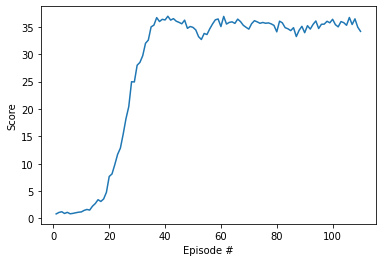

In [8]:
from ddpq_agent import Agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(device, 
              n_agents, 
              state_size, 
              action_size,
              random_seed=47,
              buffer_size=int(1e5), # replay buffer size
              batch_size=128,       # minibatch size
              gamma=0.98,           # discount factor
              tau=1e-3,             # for soft update of target parameters
              fc1_units_actor=512,  # output dim of first FC layer of actor
              fc2_units_actor=64,   # output dim of second FC layer of actor
              fcs1_units_critic=512,# output dim of first FC layer of critic
              fc2_units_critic=64,  # output dim of second FC layer of critic
              lr_actor=5e-4,        # learning rate of the actor 
              lr_critic=5e-4,       # learning rate of the critic
              weight_decay=0)       # L2 weight decay


# train the agent
ddpg_train(agent)

### 4. Watch the Agent

In [13]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
episode_scores = np.zeros(n_agents) # score for each agent within episode
agent.reset()

for t in range(1000):
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    
    # Sum up rewards separately for each agent
    episode_scores += np.array(rewards)

    # Prepare for next timestep of iteraction
    states = next_states  # new states become the current states

    # Check if any of the agents has finished. Finish to keep all
    # trajectories in this batch the same size.
    if np.any(dones):
        break

episode_score = np.mean(episode_scores) # Summary of scores for this episode
print("Episode Score (averaged across agents): {}".format(episode_score))

Episode Score (averaged across agents): 38.973499128874394


When finished, you can close the environment.

In [14]:
env.close()